In [1]:
import os
import time 
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

import bsuite
from bsuite import sweep

"tensorflow version: ", tf.__version__

('tensorflow version: ', '2.1.0')

### Bandit task
> Finite-armed bandit with deterministic rewards [0, 0.1, ..1] (Gittins, 1979). 20 seeds.

**TODO: Implement the 3 different tasks as proposed in "Learning to Reinforcement learn"**

In [2]:
bsuite_id = sweep.BANDIT[0]
env = bsuite.load_from_id(bsuite_id)
print('bsuite_id={}, settings={}, num_episodes={}'
        .format(bsuite_id, sweep.SETTINGS[bsuite_id], 
                env.bsuite_num_episodes))
vars(env)

Loaded bsuite_id: bandit/0.
bsuite_id=bandit/0, settings={'seed': None}, num_episodes=10000


{'_reset_next_step': True,
 '_rng': RandomState(MT19937) at 0x15538A270,
 '_n_actions': 11,
 '_rewards': array([0.7, 0.4, 0.3, 0.5, 0. , 0.2, 0.1, 1. , 0.8, 0.6, 0.9]),
 '_total_regret': 0.0,
 '_optimal_return': 1.0,
 'bsuite_num_episodes': 10000}

In [3]:
BASE_PATH = 'results/'

bandit_tasks = sweep.BANDIT[:5]
bandit_tasks

('bandit/0', 'bandit/1', 'bandit/2', 'bandit/3', 'bandit/4')

### Random Agent
> Chooses the next action at random

In [5]:
SAVE_PATH_RAND = os.path.join(os.getcwd(), BASE_PATH, 'rand')

def run_random_agent(bsuite_id, save_path=SAVE_PATH_RAND, 
                     overwrite=True):
    """ Evaluates a random agent experiment 
        on a single bsuite_id.
    """
    env = bsuite.load_and_record(bsuite_id, 
                                 save_path, overwrite=overwrite)
    for episode in range(env.bsuite_num_episodes):
        timestep = env.reset()
        while not timestep.last():
            action = np.random.choice(env.action_spec().num_values)
            timestep = env.step(action)
    return

In [70]:
# for bsuite_id in sweep.BANDIT[:5]:
#     run_random_agent(bsuite_id)
    
# for bsuite_id in sweep.BANDIT_NOISE[:5]:
#     run_random_agent(bsuite_id)
    
# for bsuite_id in sweep.BANDIT_SCALE[:5]:
#     run_random_agent(bsuite_id)

for bsuite_id in sweep.MEMORY_LEN[:5]:
    run_random_agent(bsuite_id)

for bsuite_id in sweep.MEMORY_SIZE[:5]:
    run_random_agent(bsuite_id)

for bsuite_id in sweep.CARTPOLE_SWINGUP[:5]:
    run_random_agent(bsuite_id)

for bsuite_id in sweep.DISCOUNTING_CHAIN[:5]:
    run_random_agent(bsuite_id)


Loaded bsuite_id: memory_len/0.
Logging results to CSV file for each bsuite_id in /Users/robvangastel/Git/meta-learners/results/rand.
Loaded bsuite_id: memory_len/1.
Logging results to CSV file for each bsuite_id in /Users/robvangastel/Git/meta-learners/results/rand.
Loaded bsuite_id: memory_len/2.
Logging results to CSV file for each bsuite_id in /Users/robvangastel/Git/meta-learners/results/rand.
Loaded bsuite_id: memory_len/3.
Logging results to CSV file for each bsuite_id in /Users/robvangastel/Git/meta-learners/results/rand.
Loaded bsuite_id: memory_len/4.
Logging results to CSV file for each bsuite_id in /Users/robvangastel/Git/meta-learners/results/rand.
Loaded bsuite_id: memory_size/0.
Logging results to CSV file for each bsuite_id in /Users/robvangastel/Git/meta-learners/results/rand.
Loaded bsuite_id: memory_size/1.
Logging results to CSV file for each bsuite_id in /Users/robvangastel/Git/meta-learners/results/rand.
Loaded bsuite_id: memory_size/2.
Logging results to CSV file

In [68]:
# The results are stored at,
!head results/rand/bsuite_id_-_bandit-0.csv

steps,episode,total_return,episode_len,episode_return,total_regret
1,1,0.30000000000000004,1,0.30000000000000004,0.7
2,2,0.4,1,0.1,1.6
3,3,0.6000000000000001,1,0.2,2.4000000000000004
4,4,1.4000000000000001,1,0.8,2.6000000000000005
5,5,1.9000000000000001,1,0.5,3.1000000000000005
6,6,2.7,1,0.8,3.3000000000000007
7,7,3.3000000000000003,1,0.6000000000000001,3.7000000000000006
8,8,3.5000000000000004,1,0.2,4.500000000000001
9,9,3.6000000000000005,1,0.1,5.400000000000001


### MAML with Reinforcement Learning
> Based on [**MAML: Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks**](https://arxiv.org/abs/1703.03400). We propose an algorithm for meta-learning that is model-agnostic, in the sense that it is compatible with any model trained with gradient descent and applicable to a variety of different learning problems, including classification, regression, and reinforcement learning.

In [13]:
from baselines.trpo_mpi import trpo_mpi

SAVE_MAML_RL_RAND = os.path.join(os.getcwd(), BASE_PATH, 'MAML_RL')

In [14]:
trpo_mpi

<module 'baselines.trpo_mpi.trpo_mpi' from '/Users/robvangastel/Git/meta-learners/baselines/baselines/trpo_mpi/trpo_mpi.py'>

### Learning to Reinforcement Learn
> Based on [**Learning to reinforcement learn**](https://arxiv.org/abs/1611.05763). A critical present objective is thus to develop deep RL methods that can adapt rapidly to new tasks. In the present work we introduce a novel approach to this challenge, which we refer to as deep meta-reinforcement learning.

In [11]:
def run_actor_critic_rnn(model, bsuite_id, 
                        save_path=SAVE_PATH_A2C, 
                        overwrite=True):
    """ Evaluates a A2C with LSTM agent experiment 
        on a single bsuite_id.
    """
    env = bsuite.load_and_record(bsuite_id, 
                                 save_path, 
                                 overwrite=True)
    agent = model.default_agent(
        obs_spec=env.observation_spec(),
        action_spec=env.action_spec())
    experiment.run(agent, env, num_episodes=env.bsuite_num_episodes)

In [12]:
from bsuite.baselines.tf import actor_critic_rnn
from bsuite.baselines import experiment

SAVE_PATH_A2C = os.path.join(os.getcwd(), BASE_PATH, 'A2C')

for bsuite_id in bandit_tasks:
    run_actor_critic_rnn(actor_critic_rnn, bsuite_id)

Loaded bsuite_id: bandit/0.
Logging results to CSV file for each bsuite_id in /Users/robvangastel/Git/meta-learners/results/A2C.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Loaded bsuite_id: bandit/1.
Logging results to CSV file for each bsuite_id in /Users/robvangastel/Git/meta-learners/results/A2C.
Loaded bsuite_id: bandit/2.
Logging results to CSV file for each bsuite_id in /Users/robvangastel/Git/meta-learners/results/A2C.
Loaded bsuite_id: bandit/3.
Logging results to CSV file for each bsuite_id in /Users/robvangastel/Git/meta-learners/results/A2C.
Loaded bsuite_id: bandit/4.
Logging results to CSV file for each bsuite_id in /Users/robvangastel/Git/meta-learners/results/A2C.


### PEARL
> Based on [**PEARL: Efficient Off-policy Meta-learning via Probabilistic Context Variables**](https://arxiv.org/abs/1903.08254). Deep reinforcement learning algorithms require large amounts of experience to learn an individual task. While in principle meta-reinforcement learning (meta-RL) algorithms enable agents to learn new skills from small amounts of experience, several major challenges preclude their practicality.

### Visualize experimental results
> Using the behavioral suite for Reinforcement Learning

**TODO: Use given Bsuite methods**

In [71]:
from bsuite.logging import csv_load
from bsuite.experiments import summary_analysis

from bsuite.experiments.bandit import analysis as bandit_analysis


SWEEP_VARS = ['agent_name']

df1, _ = csv_load.load_bsuite(SAVE_PATH_RAND)
df2, _ = csv_load.load_bsuite(SAVE_PATH_A2C)

df = pd.concat([df1, df2], axis=0)
df = df.reset_index()

df['agent_name'] = df['agent_name'].str.replace(
    '/Users/robvangastel/Git/meta-learners/results/rand', 'Random')
df['agent_name'] = df['agent_name'].str.replace(
    '/Users/robvangastel/Git/meta-learners/results/A2C', 'A2C LSTM')


df

,index,steps,episode,total_return,episode_len,episode_return,total_perfect,total_regret,bsuite_id,results_dir,...,reward_scale,height_threshold,x_reward_threshold,size,mapping_seed,memory_length,num_bits,n_distractor,chain_length,agent_name
0,0,2,1,-1.0,2,-1.0,0.0,2.0,memory_len/0,/Users/robvangastel/Git/meta-learners/results/...,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,Random
1,1,4,2,-2.0,2,-1.0,0.0,4.0,memory_len/0,/Users/robvangastel/Git/meta-learners/results/...,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,Random
2,2,6,3,-1.0,2,1.0,1.0,4.0,memory_len/0,/Users/robvangastel/Git/meta-learners/results/...,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,Random
3,3,8,4,0.0,2,1.0,2.0,4.0,memory_len/0,/Users/robvangastel/Git/meta-learners/results/...,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,Random
4,4,10,5,1.0,2,1.0,3.0,4.0,memory_len/0,/Users/robvangastel/Git/meta-learners/results/...,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,Random
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1824,240,6000,6000,5970.7,1,1.0,NaN,29.3,bandit/0,/Users/robvangastel/Git/meta-learners/results/A2C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A2C LSTM
1825,241,7000,7000,6970.7,1,1.0,NaN,29.3,bandit/0,/Users/robvangastel/Git/meta-learners/results/A2C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A2C LSTM
1826,242,8000,8000,7970.7,1,1.0,NaN,29.3,bandit/0,/Users/robvangastel/Git/meta-learners/results/A2C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A2C LSTM
1827,243,9000,9000,8970.7,1,1.0,NaN,29.3,bandit/0,/Users/robvangastel/Git/meta-learners/results/A2C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A2C LSTM


/Users/robvangastel/.conda/envs/rl/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal


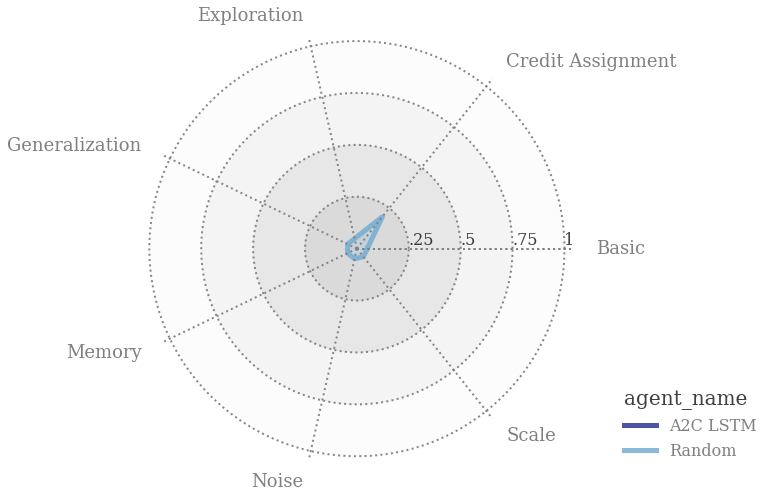

In [72]:
BSUITE_SCORE = summary_analysis.bsuite_score(df, SWEEP_VARS)
BSUITE_SUMMARY = summary_analysis.ave_score_by_tag(BSUITE_SCORE, SWEEP_VARS)
__radar_fig__ = summary_analysis.bsuite_radar_plot(BSUITE_SUMMARY, SWEEP_VARS)

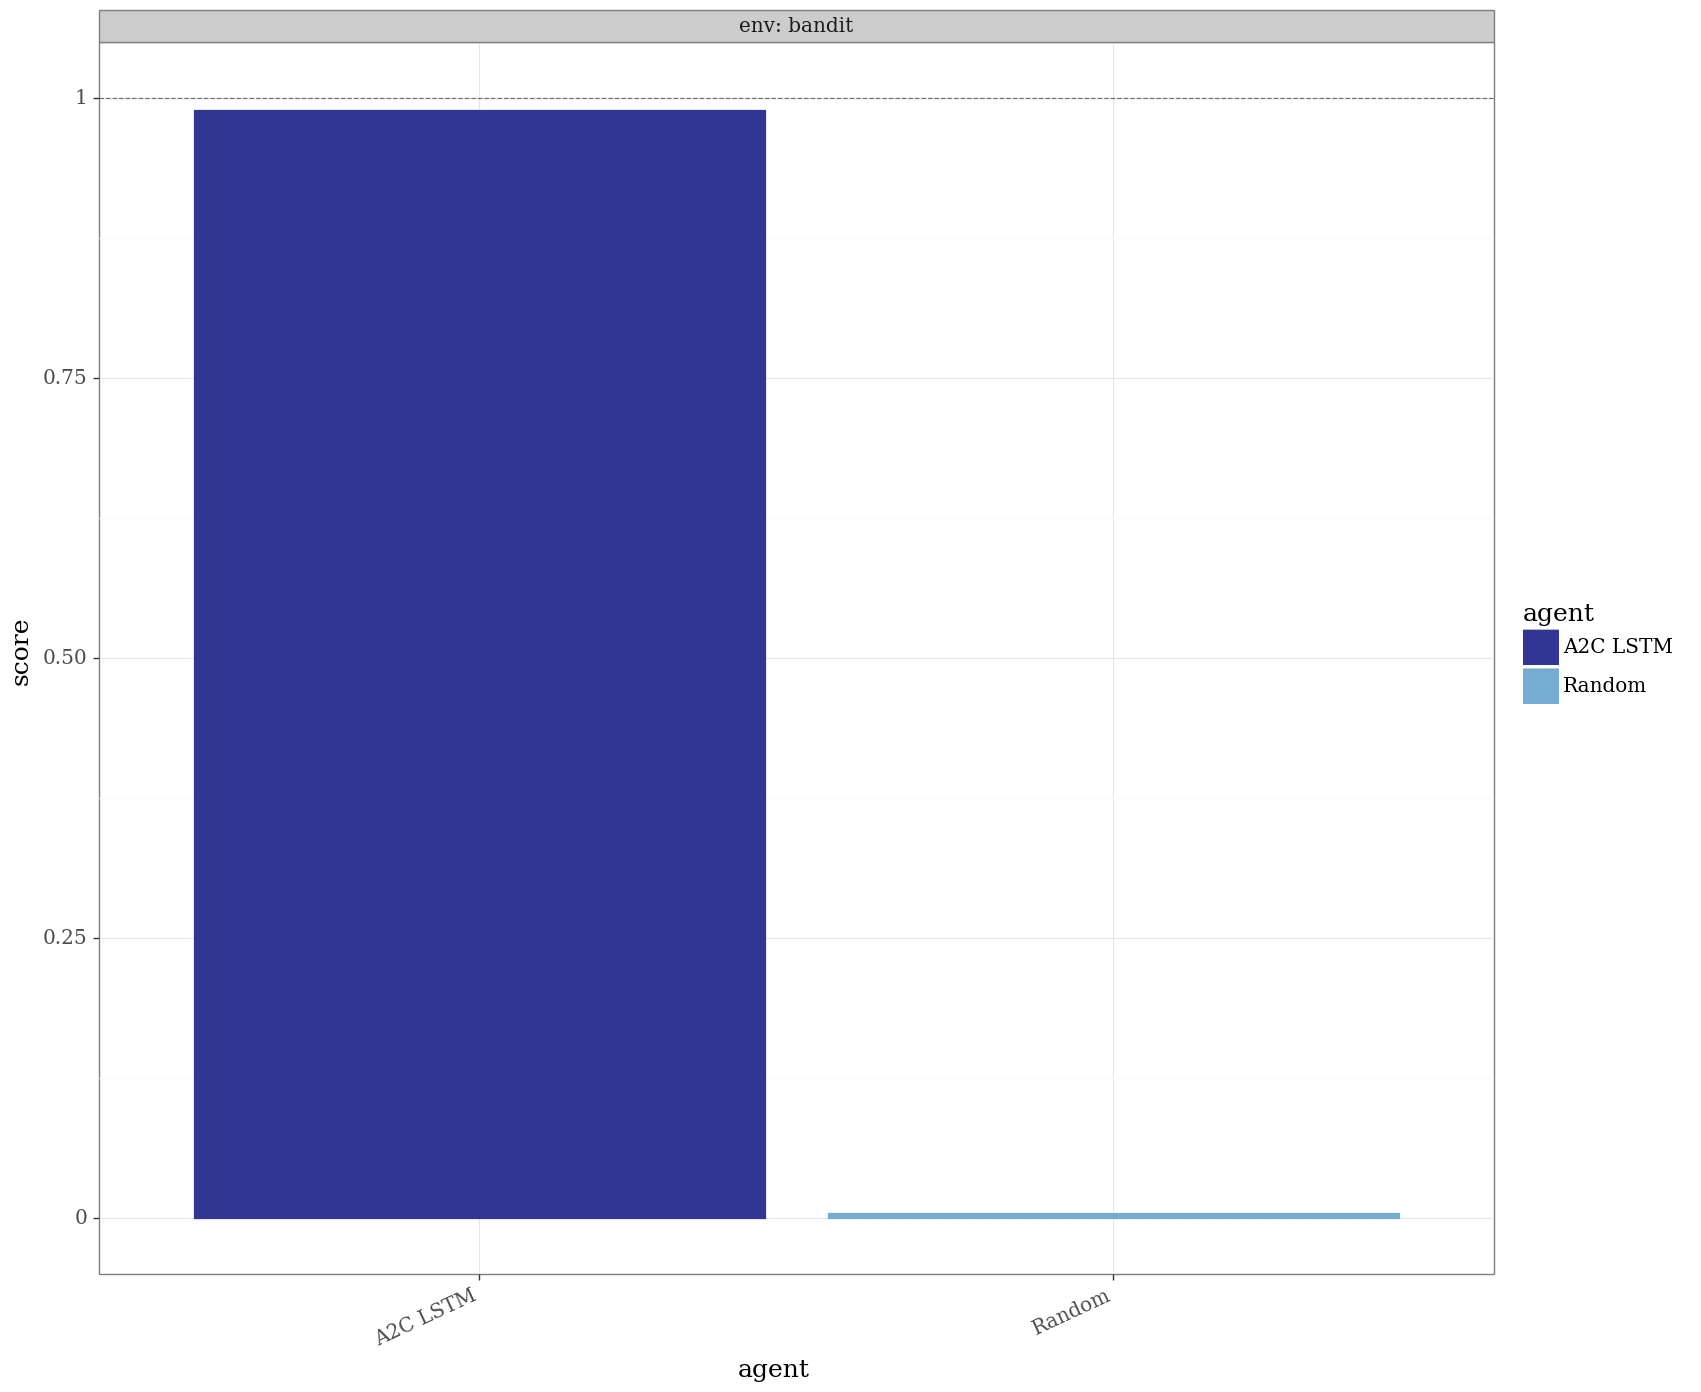

<ggplot: (364642289)>

In [60]:
summary_analysis.bsuite_bar_plot_compare(BSUITE_SCORE, SWEEP_VARS)

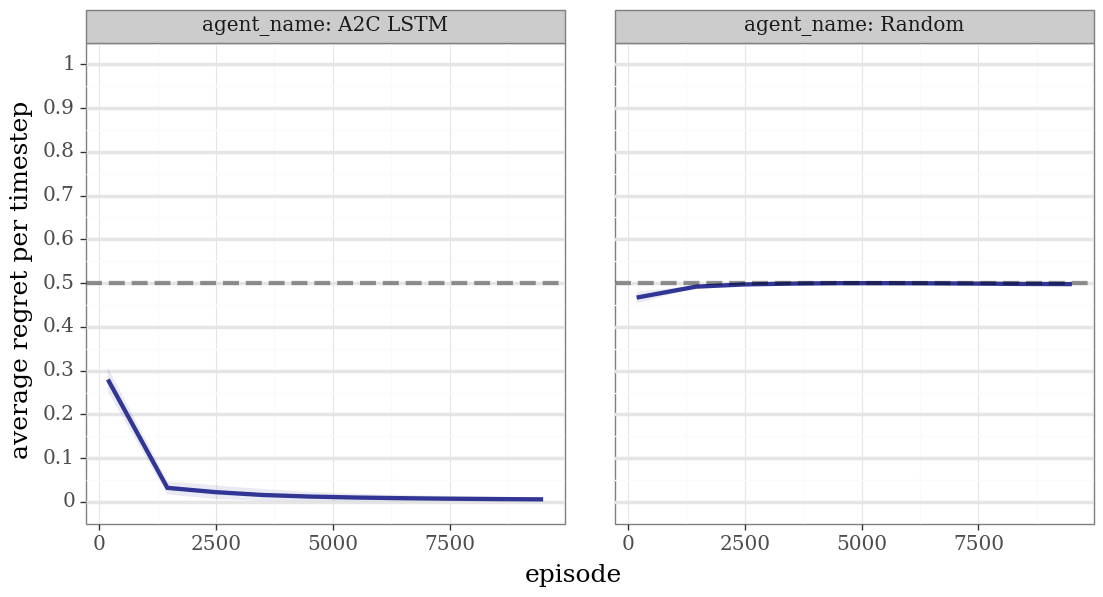

<ggplot: (364641077)>

In [62]:
bandit_analysis.plot_learning(df, SWEEP_VARS)